In [1]:
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [3]:
trn_ds = MNIST('', transform=img_transform, train=True, download=True)
val_ds = MNIST('', transform=img_transform, train=False, download=True)

In [4]:
import torch.nn as nn
import torch

class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128), nn.ReLU(True),
            nn.Linear(128,64), nn.ReLU(True),
            nn.Linear(64,latent_dim))
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,64),nn.ReLU(True),
            nn.Linear(64,128),nn.ReLU(True),
            nn.Linear(128,28*28),nn.Tanh())

    def forward(self,x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [5]:
def train_batch(input,model,criterio,optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input,model,criterion):
    model.eval()
    output = model(input)
    loss = criterion(output,input)
    return loss

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

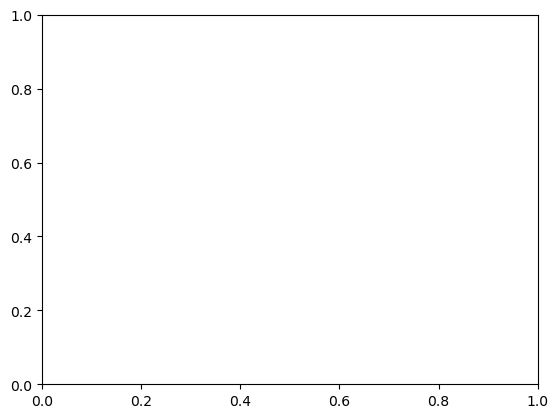

In [12]:
from fastprogress import master_bar, progress_bar

model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = {'train_loss': [], 'val_loss': []}  # Usando um dicionário simples para armazenar as perdas

# Usando master_bar para controlar o progresso
mb = master_bar(range(num_epochs))

for epoch in mb:
    model.train()
    N = len(trn_ds)
    total_train_loss = 0
    for ix, (data, _) in enumerate(progress_bar(trn_ds, parent=mb)):
        loss = train_batch(data, model, criterion, optimizer)
        total_train_loss += loss
    avg_train_loss = total_train_loss / N
    log['train_loss'].append(avg_train_loss)

    model.eval()
    N = len(val_ds)
    total_val_loss = 0
    for ix, (data, _) in enumerate(progress_bar(val_ds, parent=mb)):
        loss = validate_batch(data, model, criterion)
        total_val_loss += loss
    avg_val_loss = total_val_loss / N
    log['val_loss'].append(avg_val_loss)

    # Atualizando o progresso
    mb.write(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plotando os logs de treinamento
import matplotlib.pyplot as plt
plt.plot(log['train_loss'], label='Train Loss')
plt.plot(log['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model = AutoEncoder(3).to(device)

for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()